In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import pymysql

In [6]:
np.random.seed(42)

In [7]:
conn = pymysql.connect(host='localhost', user='tfm_user', password='tfmdatabase1234', db='tfm_database')

In [8]:
df_inmueble = pd.read_sql("SELECT * FROM inmueble", conn)
df_direccion = pd.read_sql("SELECT * FROM direccion", conn)
df_anuncio = pd.read_sql("SELECT * FROM anuncio", conn)

In [9]:
inmueble_cols = list(set(df_inmueble.columns) - set(["descripcion", "certificado_energetico"]))
direccion_cols = ["id_direccion", "ha_zonasverdes", "distrito"]
anuncio_cols = ["id_inmueble", "precio", "tipo"]

In [10]:
df_inmueble_ml = df_inmueble[inmueble_cols]
df_direccion_ml = df_direccion[direccion_cols]
df_anuncio_ml = df_anuncio[anuncio_cols]

In [11]:
df_ml = df_anuncio_ml.merge(df_inmueble_ml, on="id_inmueble", how="inner")
df_ml = df_ml.merge(df_direccion_ml, on="id_direccion", how="inner")
df_ml_compra = df_ml[df_ml.tipo == "compra"]
df_ml_alquiler = df_ml[df_ml.tipo == "alquiler"]
df_ml_compra = df_ml_compra[list(set(df_ml_compra.columns) - set(["id_inmueble", "id_direccion", "tipo"]))]
df_ml_alquiler = df_ml_alquiler[list(set(df_ml_alquiler.columns) - set(["id_inmueble", "id_direccion", "tipo"]))]

In [12]:
df_ml2_compra = pd.get_dummies(df_ml_compra)
df_ml2_alquiler = pd.get_dummies(df_ml_alquiler)

In [13]:
def prepare_datasets(X, y):
    scaler_x = MinMaxScaler()
    X_scale = scaler_x.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scale = scaler_y.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y_scale, test_size=0.3)

    return scaler_x, scaler_y, X_train, X_test, y_train, y_test

# ML Compra

In [53]:
X_cols = list(set(df_ml2_compra.columns) - set(["precio"]))
y_cols = ["precio"]
X_compra = df_ml2_compra[X_cols]
y_compra = df_ml2_compra[y_cols]

In [14]:
scaler_x, scaler_y, X_train, X_test, y_train, y_test = prepare_datasets(X_compra, y_compra)

In [15]:
import joblib

joblib.dump(scaler_x, "scaler_x_compra.joblib")

['scaler_x_compra.joblib']

## Linear Regression

In [16]:
model_linear_compra = LinearRegression()

model_linear_compra.fit(X_train, y_train)

LinearRegression()

In [17]:
prediction_linear = model_linear_compra.predict(X_test)

mean_squared_error(scaler_y.transform(y_test), scaler_y.transform(prediction_linear))

c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


0.0010652396140664253

In [18]:
r2_score(y_test, prediction_linear)

0.8218008259665702

## Random Forest

In [19]:
model_rand_forest_compra = RandomForestRegressor()

model_rand_forest_compra.fit(X_train, y_train)

c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor()

In [20]:
prediction = model_rand_forest_compra.predict(X_test)

mean_squared_error(scaler_y.transform(y_test), scaler_y.transform(prediction.reshape(-1,1)))

c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


6.112417109961e-05

In [21]:
r2_score(y_test, prediction)

0.9897748106063681

In [ ]:
df_plot_alquiler = pd.DataFrame([[random_forest_train_score,random_forest_train_mse,"Random Forest", "Train"],[random_forest_test_score, random_forest_test_mse, "Random Forest", "Test"],[linear_reg_train_score, linear_reg_train_mse, "Linear Regression", "Train"],[linear_reg_test_score,linear_reg_test_mse, "Linear Regression", "Test"]], columns=["Score", "MSE", "Model", "Data"])

In [22]:
joblib.dump(model_rand_forest_compra, "model_compra.joblib")

['model_compra.joblib']

# ML Alquiler

In [14]:
X_cols = list(set(df_ml2_alquiler.columns) - set(["precio"]))
y_cols = ["precio"]
X_alquiler = df_ml2_alquiler[X_cols]
y_alquiler = df_ml2_alquiler[y_cols]

In [15]:
scaler_x, scaler_y, X_train, X_test, y_train, y_test = prepare_datasets(X_alquiler, y_alquiler)

In [31]:
import joblib

joblib.dump(scaler_x, "scaler_x_alquiler.joblib")

['scaler_x_alquiler.joblib']

## Linear Regression

In [17]:
model_linear_alquiler = LinearRegression()

model_linear_alquiler.fit(X_train, y_train)

LinearRegression()

In [18]:
prediction_linear_test = model_linear_alquiler.predict(X_test)
prediction_linear_train = model_linear_alquiler.predict(X_train)

linear_reg_test_mse = mean_squared_error(scaler_y.transform(y_test), scaler_y.transform(prediction_linear_test))
linear_reg_train_mse = mean_squared_error(scaler_y.transform(y_train), scaler_y.transform(prediction_linear_train))

print(f"Train MSE -- Linear Regression: {linear_reg_train_mse}")
print(f"Test MSE -- Linear Regression: {linear_reg_test_mse}")

Train MSE -- Linear Regression: 4.105272571191167e-09
Test MSE -- Linear Regression: 4.170441606868138e-09


c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [19]:
linear_reg_test_score = r2_score(y_test, prediction_linear_test)
linear_reg_train_score = r2_score(y_train, prediction_linear_train)

print(f"Train Score -- Linear Regressiont: {linear_reg_train_score}")
print(f"Test Score -- Linear Regression: {linear_reg_test_score}")

Train Score -- Linear Regressiont: 0.764281046993852
Test Score -- Linear Regression: 0.7557788472139244


## Random Forest

In [20]:
model_rand_forest_alquiler = RandomForestRegressor()

model_rand_forest_alquiler.fit(X_train, y_train)

prediction_rand_forest_test = model_rand_forest_alquiler.predict(X_test)
prediction_rand_forest_train = model_rand_forest_alquiler.predict(X_train)

c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
random_forest_test_mse = mean_squared_error(scaler_y.transform(y_test), scaler_y.transform(prediction_rand_forest_test.reshape(-1,1)))
random_forest_train_mse = mean_squared_error(scaler_y.transform(y_train), scaler_y.transform(prediction_rand_forest_train.reshape(-1,1)))

print(f"Train MSE -- Random Forest: {random_forest_train_mse}")
print(f"Test MSE -- Random Forest: {random_forest_test_mse}")

Train MSE -- Random Forest: 7.588980110210483e-11
Test MSE -- Random Forest: 4.4391869004000117e-10


c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [60]:
pd.DataFrame(np.array([list(y_test.precio.values), list(prediction_test)]).reshape(-1,2), columns=["test", "pred"], index = range(0,len(list(y_test.precio.values))))

,test,pred
0,1553.00,1797.000000
1,1485.00,2432.000000
2,2514.00,942.000000
3,1138.00,1081.000000
4,871.00,979.000000
...,...,...
14215,1472.91,1885.400000
14216,2143.19,2309.500000
14217,1654.36,1115.060000
14218,961.65,895.085833


In [22]:
random_forest_test_score = r2_score(y_test, prediction_rand_forest_test)
random_forest_train_score = r2_score(y_train, prediction_rand_forest_train)

print(f"Train Score -- Random Forest: {random_forest_train_score}")
print(f"Test Score -- Random Forest: {random_forest_test_score}")

Train Score -- Random Forest: 0.9956425148027521
Test Score -- Random Forest: 0.9740041116877621


In [99]:
df_ml[df_ml.tipo=="compra"].precio.max()

8800000.0

In [37]:
#Parámetros:
distrito = "chamartin"
num_piso = "5"
orientacion = "sur"
terraza = True
num_lavabos = 2
parking = False
exterior = True
ascensor = True
superficie = 180
num_habitaciones = 3
balcon = False
piscina = True

cols = ['piso_4', 'distrito_moratalaz', 'tipo_propiedad_duplex',
       'orientacion_norte', 'piso_9', 'tipo_propiedad_pisos',
       'distrito_villaverde', 'distrito_chamberi', 'num_lavabos',
       'distrito_tetuan', 'piso_6', 'num_habitaciones', 'superficie',
       'distrito_ciudad lineal', 'piso_7', 'piso_0', 'ascensor',
       'tipo_propiedad_aticos', 'terraza', 'piscina', 'distrito_chamartin',
       'distrito_vicalvaro', 'distrito_moncloa', 'orientacion_sur',
       'distrito_barajas', 'distrito_hortaleza', 'distrito_usera',
       'orientacion_oeste', 'piso_8', 'piso_3', 'distrito_retiro',
       'distrito_carabanchel', 'orientacion_este', 'parking',
       'distrito_puente de vallecas', 'distrito_villa de vallecas', 'piso_5',
       'piso_1', 'distrito_arganzuela', 'piso_2', 'distrito_centro',
       'distrito_latina', 'ha_zonasverdes', 'exterior', 'distrito_fuencarral',
       'distrito_salamanca', 'balcon']

df = pd.DataFrame(np.zeros(len(cols),dtype=np.int32).reshape(1,-1), columns=cols)

#Parametros
df["terraza"] = int(terraza)
df["num_lavabos"] = int(num_lavabos)
df["parking"] = int(parking)
df["exterior"] = int(exterior)
df["ascensor"] = int(ascensor)
df["superficie"] = int(superficie)
df["num_habitaciones"] = int(num_habitaciones)
df["balcon"] = int(balcon)
df["piscina"] = int(piscina)
df[f"distrito_{distrito}"] = 1
df[f"piso_{num_piso}"] = 1
df[f"orientacion_{orientacion}"] = 1

df_scale_alquiler = scaler_x.transform(df)
prediction_alquiler = model_rand_forest_alquiler.predict(df_scale_alquiler)

c:\Users\aaira\OneDrive\Documentos\tfm_eae\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [38]:
scaler_y.inverse_transform(prediction_alquiler.reshape(1,-1))

array([[798.95]])

In [76]:
!pip install xgboost

  Using cached xgboost-1.6.2-py3-none-win_amd64.whl (125.4 MB)


You should consider upgrading via the 'c:\users\aaira\onedrive\documentos\tfm_eae\myenv\scripts\python.exe -m pip install --upgrade pip' command.


In [27]:
import xgboost as xgb

In [28]:
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42)
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)


In [30]:
scaler_y.inverse_transform(y_pred.reshape(1,-1))

array([[1436.61  , 1771.8088, 1525.1814, ...,  837.2432, 1168.9717,
        1221.6355]], dtype=float32)

In [41]:
prediction_alquiler_xgb = xgb_regressor.predict(df_scale_alquiler)

In [42]:
scaler_y.inverse_transform(prediction_alquiler_xgb.reshape(-1,1))

array([[768.687]], dtype=float32)

In [137]:
scaler_y.inverse_transform(prediction_alquiler.reshape(-1,1))

array([[947.23142857]])

In [98]:
scaler_y.inverse_transform(y_test)

array([[1496.],
       [ 743.],
       [1122.],
       ...,
       [ 535.],
       [ 979.],
       [1950.]])

In [99]:
scaler_y.inverse_transform(y_pred.reshape(-1,1))

array([[1561.76   ],
       [ 698.73285],
       [1060.9255 ],
       ...,
       [ 558.60986],
       [ 938.7393 ],
       [1786.5328 ]], dtype=float32)

In [119]:
scaler_y.inverse_transform(prediction_rand_forest_test.reshape(-1,1))

array([[1501.98     ],
       [ 723.2528254],
       [1113.32     ],
       ...,
       [ 541.02     ],
       [ 879.82     ],
       [1950.       ]])

In [104]:
X_test[0,:]

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.14285714, 0.        ,
       0.        , 0.28571429, 0.16124031, 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.12845403, 0.        , 0.        ,
       0.        , 0.        ])

In [112]:
importance_scores = xgb_regressor.feature_importances_

feature_names = X_alquiler.columns

# Create a list of tuples with feature names and their importance scores
feature_importance_list = list(zip(feature_names, importance_scores))

# Sort the list by importance scores in descending order
feature_importance_list.sort(key=lambda x: x[1], reverse=True)


In [113]:
feature_importance_list

[('ha_zonasverdes', 0.21582854),
 ('superficie', 0.10409194),
 ('ascensor', 0.083828196),
 ('distrito_usera', 0.06957047),
 ('distrito_carabanchel', 0.05561314),
 ('distrito_villaverde', 0.04866381),
 ('num_lavabos', 0.0394291),
 ('piscina', 0.031150794),
 ('distrito_moncloa', 0.029766262),
 ('distrito_puente de vallecas', 0.025995608),
 ('distrito_villa de vallecas', 0.023718916),
 ('tipo_propiedad_aticos', 0.017765705),
 ('piso_0', 0.017572185),
 ('piso_9', 0.012957644),
 ('parking', 0.012521335),
 ('distrito_moratalaz', 0.012190154),
 ('distrito_chamartin', 0.012129704),
 ('distrito_salamanca', 0.011835762),
 ('piso_8', 0.01037398),
 ('num_habitaciones', 0.009906537),
 ('distrito_latina', 0.009801726),
 ('distrito_vicalvaro', 0.009493509),
 ('piso_2', 0.009163918),
 ('distrito_chamberi', 0.0075079254),
 ('piso_3', 0.007057857),
 ('piso_1', 0.006989887),
 ('exterior', 0.0066698547),
 ('tipo_propiedad_pisos', 0.006504514),
 ('distrito_centro', 0.0064146165),
 ('distrito_hortaleza', 0.

In [109]:
scaler_x.inverse_transform(X_test[0,:].reshape(1,-1))

array([[  1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
          2.  ,   0.  ,   0.  ,   4.  , 120.  ,   0.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,  55.98,   0.  ,   0.  ,   0.  ,   0.  ]])

In [110]:
pd.DataFrame(scaler_x.inverse_transform(X_test[0,:].reshape(1,-1)), columns=cols)

,distrito_tetuan,terraza,distrito_vicalvaro,piso_7,num_lavabos,piso_6,orientacion_norte,distrito_carabanchel,distrito_latina,distrito_salamanca,...,distrito_usera,distrito_chamartin,piso_2,ha_zonasverdes,piso_5,piso_9,orientacion_oeste,distrito_moratalaz,distrito_chamberi,distrito_barajas
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,55.98,0.0,0.0,0.0,0.0


In [115]:
pd.DataFrame(scaler_x.inverse_transform(X_test[0,:].reshape(1,-1)), columns=X_alquiler.columns)

,piso_4,distrito_moratalaz,tipo_propiedad_duplex,orientacion_norte,piso_9,tipo_propiedad_pisos,distrito_villaverde,distrito_chamberi,num_lavabos,distrito_tetuan,...,piso_1,distrito_arganzuela,piso_2,distrito_centro,distrito_latina,ha_zonasverdes,exterior,distrito_fuencarral,distrito_salamanca,balcon
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,55.98,0.0,0.0,0.0,0.0


In [114]:
X_alquiler.columns

Index(['piso_4', 'distrito_moratalaz', 'tipo_propiedad_duplex',
       'orientacion_norte', 'piso_9', 'tipo_propiedad_pisos',
       'distrito_villaverde', 'distrito_chamberi', 'num_lavabos',
       'distrito_tetuan', 'piso_6', 'num_habitaciones', 'superficie',
       'distrito_ciudad lineal', 'piso_7', 'piso_0', 'ascensor',
       'tipo_propiedad_aticos', 'terraza', 'piscina', 'distrito_chamartin',
       'distrito_vicalvaro', 'distrito_moncloa', 'orientacion_sur',
       'distrito_barajas', 'distrito_hortaleza', 'distrito_usera',
       'orientacion_oeste', 'piso_8', 'piso_3', 'distrito_retiro',
       'distrito_carabanchel', 'orientacion_este', 'parking',
       'distrito_puente de vallecas', 'distrito_villa de vallecas', 'piso_5',
       'piso_1', 'distrito_arganzuela', 'piso_2', 'distrito_centro',
       'distrito_latina', 'ha_zonasverdes', 'exterior', 'distrito_fuencarral',
       'distrito_salamanca', 'balcon'],
      dtype='object')

In [105]:
cols

['distrito_tetuan',
 'terraza',
 'distrito_vicalvaro',
 'piso_7',
 'num_lavabos',
 'piso_6',
 'orientacion_norte',
 'distrito_carabanchel',
 'distrito_latina',
 'distrito_salamanca',
 'tipo_propiedad_pisos',
 'tipo_propiedad_duplex',
 'distrito_arganzuela',
 'distrito_hortaleza',
 'tipo_propiedad_aticos',
 'piso_1',
 'piso_8',
 'piscina',
 'piso_3',
 'piso_0',
 'distrito_villaverde',
 'parking',
 'distrito_ciudad lineal',
 'exterior',
 'distrito_centro',
 'distrito_villa de vallecas',
 'orientacion_este',
 'distrito_puente de vallecas',
 'orientacion_sur',
 'distrito_fuencarral',
 'distrito_moncloa',
 'ascensor',
 'superficie',
 'piso_4',
 'num_habitaciones',
 'balcon',
 'distrito_retiro',
 'distrito_usera',
 'distrito_chamartin',
 'piso_2',
 'ha_zonasverdes',
 'piso_5',
 'piso_9',
 'orientacion_oeste',
 'distrito_moratalaz',
 'distrito_chamberi',
 'distrito_barajas']

In [97]:
r2_score(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred.reshape(-1,1)))

0.953743282644606

In [92]:
scaler_y.inverse_transform(prediction_alquiler.reshape(-1,1))

array([[715.2]])

In [128]:
import seaborn as sns

In [135]:
df_plot_alquiler = pd.DataFrame([[random_forest_train_score,random_forest_train_mse,"Random Forest", "Train"],[random_forest_test_score, random_forest_test_mse, "Random Forest", "Test"],[linear_reg_train_score, linear_reg_train_mse, "Linear Regression", "Train"],[linear_reg_test_score,linear_reg_test_mse, "Linear Regression", "Test"]], columns=["Score", "MSE", "Model", "Data"])

In [138]:
df_plot_alquiler

,Score,MSE,Model,Data
0,0.996429,8.961130e-07,Random Forest,Train
1,0.952891,1.197755e-05,Random Forest,Test
2,0.079845,2.309273e-04,Linear Regression,Train
3,0.081923,2.334223e-04,Linear Regression,Test


<AxesSubplot:xlabel='Data', ylabel='Score'>

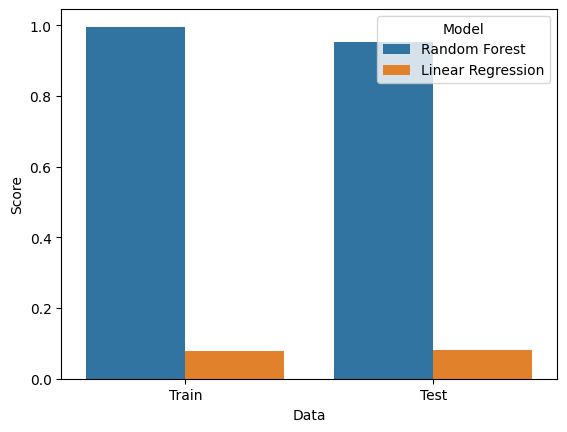

In [139]:
sns.barplot(data = df_plot_alquiler, x="Data", y="Score", hue="Model")

<AxesSubplot:xlabel='Data', ylabel='MSE'>

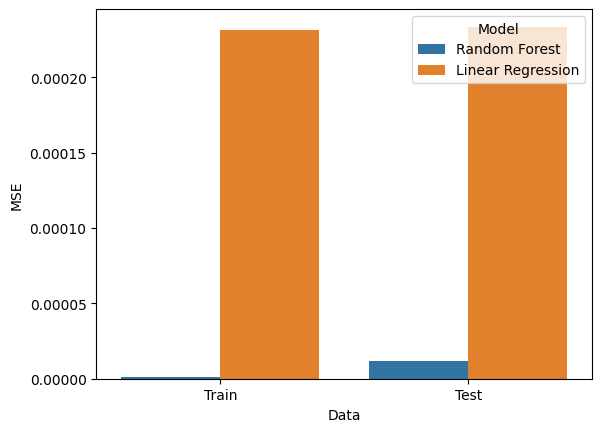

In [140]:
sns.barplot(data = df_plot_alquiler, x="Data", y="MSE", hue="Model")

In [141]:
import joblib

In [41]:
joblib.dump(model_rand_forest_alquler, "model_alquiler.joblib")

['model_alquiler.joblib']

In [143]:
joblib.dump(model_rand_forest_compra, "model_compra.joblib")

['model_compra.joblib']

In [144]:
X.columns

Index(['distrito_tetuan', 'terraza', 'distrito_vicalvaro', 'piso_7',
       'num_lavabos', 'piso_6', 'orientacion_norte', 'distrito_carabanchel',
       'distrito_latina', 'distrito_salamanca', 'tipo_propiedad_pisos',
       'tipo_propiedad_duplex', 'distrito_arganzuela', 'distrito_hortaleza',
       'tipo_propiedad_aticos', 'piso_1', 'piso_8', 'piscina', 'piso_3',
       'piso_0', 'distrito_villaverde', 'parking', 'distrito_ciudad lineal',
       'exterior', 'distrito_centro', 'distrito_villa de vallecas',
       'orientacion_este', 'distrito_puente de vallecas', 'orientacion_sur',
       'distrito_fuencarral', 'distrito_moncloa', 'ascensor', 'superficie',
       'piso_4', 'num_habitaciones', 'balcon', 'distrito_retiro',
       'distrito_usera', 'distrito_chamartin', 'piso_2', 'ha_zonasverdes',
       'piso_5', 'piso_9', 'orientacion_oeste', 'distrito_moratalaz',
       'distrito_chamberi', 'distrito_barajas'],
      dtype='object')

In [153]:
X_train.shape

(37235, 47)

In [ ]:
distrito = "arganzuela"
subdistrito = "palos de la frontera"
num_habitaciones = 2
num_lavabos = 1
superficie = 60
tipo_propiedad = "piso"
exterior = 1
ascensor = 1
parking = 0
terraza = 0
balcon = 1
piscina = 0
piso = 3
orientacion = "norte"
certificado_energetico = "d"

In [158]:
X

,distrito_tetuan,terraza,distrito_vicalvaro,piso_7,num_lavabos,piso_6,orientacion_norte,distrito_carabanchel,distrito_latina,distrito_salamanca,...,distrito_usera,distrito_chamartin,piso_2,ha_zonasverdes,piso_5,piso_9,orientacion_oeste,distrito_moratalaz,distrito_chamberi,distrito_barajas
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,216.23,0,0,1,0,0,0
3,0,1,0,0,1,0,1,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
5,0,0,0,0,1,0,1,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
7,0,0,0,0,1,0,1,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
9,0,1,0,0,1,0,0,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106377,0,0,0,0,2,0,0,0,0,0,...,0,0,1,93.35,0,0,0,0,0,1
106379,0,0,0,0,1,0,1,0,0,0,...,0,0,0,93.35,0,0,0,0,0,1
106381,0,0,0,0,2,0,1,0,0,0,...,0,0,0,93.35,0,0,0,0,0,1
106383,0,0,0,0,2,0,0,0,0,0,...,0,0,1,93.35,0,0,0,0,0,1


In [159]:
X_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [169]:
X_train[0,:]

array([0.        , 1.        , 0.        , 0.        , 0.14285714,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.11731207, 0.        , 0.2       ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        ])

In [166]:
feature_importances = model_rand_forest_alquler.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for idx, importance in enumerate(feature_importances[sorted_indices]):
    feature_index = sorted_indices[idx]
    feature_name = X.columns[feature_index]  # Assuming X_train is a DataFrame
    print(f"Feature: {feature_name}, Importance: {importance}")



Feature: superficie, Importance: 0.36260386923243104
Feature: distrito_retiro, Importance: 0.27827644080655806
Feature: tipo_propiedad_aticos, Importance: 0.11893948704090133
Feature: piso_6, Importance: 0.10806651673229299
Feature: num_habitaciones, Importance: 0.027600108291007956
Feature: distrito_salamanca, Importance: 0.020595908533973563
Feature: num_lavabos, Importance: 0.02022045236912009
Feature: balcon, Importance: 0.017718821909503177
Feature: piso_2, Importance: 0.010948403435846037
Feature: parking, Importance: 0.007290146704036309
Feature: piso_4, Importance: 0.004151888543711215
Feature: piso_8, Importance: 0.0029724175592997083
Feature: piscina, Importance: 0.002642920972949276
Feature: piso_5, Importance: 0.0024190465800578
Feature: orientacion_norte, Importance: 0.002359322402311466
Feature: terraza, Importance: 0.002168317273217468
Feature: distrito_chamartin, Importance: 0.0017610427423549284
Feature: orientacion_oeste, Importance: 0.001483358535529718
Feature: dist

In [170]:
model_rand_forest_alquler.feature_names_in_

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names_in_'

In [ ]:
model_rand_forest_alquler.predict()

In [174]:
X_alquiler

,distrito_tetuan,terraza,distrito_vicalvaro,piso_7,num_lavabos,piso_6,orientacion_norte,distrito_carabanchel,distrito_latina,distrito_salamanca,...,distrito_usera,distrito_chamartin,piso_2,ha_zonasverdes,piso_5,piso_9,orientacion_oeste,distrito_moratalaz,distrito_chamberi,distrito_barajas
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,216.23,0,0,1,0,0,0
2,0,1,0,0,1,0,1,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
6,0,0,0,0,1,0,1,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
8,0,1,0,0,1,0,0,0,0,0,...,0,0,0,216.23,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106376,0,0,0,0,2,0,0,0,0,0,...,0,0,1,93.35,0,0,0,0,0,1
106378,0,0,0,0,1,0,1,0,0,0,...,0,0,0,93.35,0,0,0,0,0,1
106380,0,0,0,0,2,0,1,0,0,0,...,0,0,0,93.35,0,0,0,0,0,1
106382,0,0,0,0,2,0,0,0,0,0,...,0,0,1,93.35,0,0,0,0,0,1


In [180]:
X_test[0,:].reshape(1,-1)

array([[0.        , 1.        , 0.        , 0.        , 0.14285714,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.06947608, 0.        , 0.13333333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.34873865, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [178]:
model_rand_forest_alquler.predict(X_test[0,:].reshape(1,-1))

array([1092.34])

In [ ]:
#Parámetros:
distrito = "chamberi"
num_piso = "3"
orientacion = "norte"
terraza = 0
num_lavabos = 1
parking = 1
exterior = 1
ascensor = 0
superficie = 60
num_habitaciones = 2
balcon = 0
piscina = 0









# Código:

import joblib 
import matplotlib.pyplot as plt
import numpy as np

model_alquiler = joblib.load(r"C:\Users\aaira\OneDrive\Documentos\tfm_datos\model_alquiler.joblib")
scaler_x_alquiler = joblib.load(r"C:\Users\aaira\OneDrive\Documentos\tfm_datos\scaler_x_alquiler.joblib")

model_compra = joblib.load(r"C:\Users\aaira\OneDrive\Documentos\tfm_datos\model_compra.joblib")
scaler_x_compra = joblib.load(r"C:\Users\aaira\OneDrive\Documentos\tfm_datos\scaler_x_compra.joblib")

cols = ['piso_4', 'distrito_moratalaz', 'tipo_propiedad_duplex',
       'orientacion_norte', 'piso_9', 'tipo_propiedad_pisos',
       'distrito_villaverde', 'distrito_chamberi', 'num_lavabos',
       'distrito_tetuan', 'piso_6', 'num_habitaciones', 'superficie',
       'distrito_ciudad lineal', 'piso_7', 'piso_0', 'ascensor',
       'tipo_propiedad_aticos', 'terraza', 'piscina', 'distrito_chamartin',
       'distrito_vicalvaro', 'distrito_moncloa', 'orientacion_sur',
       'distrito_barajas', 'distrito_hortaleza', 'distrito_usera',
       'orientacion_oeste', 'piso_8', 'piso_3', 'distrito_retiro',
       'distrito_carabanchel', 'orientacion_este', 'parking',
       'distrito_puente de vallecas', 'distrito_villa de vallecas', 'piso_5',
       'piso_1', 'distrito_arganzuela', 'piso_2', 'distrito_centro',
       'distrito_latina', 'ha_zonasverdes', 'exterior', 'distrito_fuencarral',
       'distrito_salamanca', 'balcon']

df = pandas.DataFrame(np.zeros(len(cols)).reshape(1,-1), columns=cols)

#Parametros
df["terraza"] = terraza
df["num_lavabos"] = num_lavabos
df["parking"] = parking
df["exterior"] = exterior
df["ascensor"] = ascensor
df["superficie"] = superficie
df["num_habitaciones"] = num_habitaciones
df["balcon"] = balcon
df["piscina"] = piscina
df[f"distrito_{distrito}"] = 1
df[f"piso_{num_piso}"] = 1
df[f"orientacion_{orientacion}"] = 1

df_scale_alquiler = scaler_x_alquiler.transform(df)
prediction_alquiler = model_alquiler.predict(df_scale_alquiler)

df_scale_compra = scaler_x_compra.transform(df)
prediction_compra = model_compra.predict(df_scale_compra)

data = [[f"{round(prediction_compra[0]/100)*100}€ (prediccion: {round(prediction_compra[0])}€)", f"{round(prediction_alquiler[0]/10)*10}€ (prediccion: {round(prediction_alquiler[0])}€)"]]
fig, ax = plt.subplots()

table = ax.table(cellText=data, colLabels=["Precio Compra", "Precio Alquiler", "distrito"], cellLoc='center', loc='center',bbox=[0, 0.9, 1.1, 0.2])

table.get_celld()[(0, 0)].set_facecolor("red")
table.get_celld()[(0, 0)].set_text_props(fontweight='bold', color='white')
table.get_celld()[(0, 1)].set_facecolor("red")
table.get_celld()[(0, 1)].set_text_props(fontweight='bold', color='white')
table.auto_set_font_size(True)
table.scale(1.2, 1.2)
ax.axis('off')

# Show the plot
plt.show()